# Agentic RAG

https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/rag/langgraph_agentic_rag.ipynb

[Retrieval Agents](https://python.langchain.com/docs/tutorials/qa_chat_history/#agents) are useful when we want to make decisions about whether to retrieve from an index.

To implement a retrieval agent, we simply need to give an LLM access to a retriever tool.

We can incorporate this into [LangGraph](https://langchain-ai.github.io/langgraph/).

![agentic_rag](agentic_rag.png)


> **Run on WSL, windows cannot support well or embeddings!**

## Setup

First, let's download the required packages

In [1]:
# %%capture --no-stderr
# %pip install -U --quiet langchain-community tiktoken langchain-openai langchainhub chromadb langchain langgraph langchain-text-splitters
# %pip install lxml

## Retriever

First, we index 3 blog posts.

In [2]:
import os
os.environ["USER_AGENT"] = "LangChain/RAG-Application"
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_ollama import OllamaEmbeddings
from langchain_community.document_loaders import MHTMLLoader
from pathlib import Path

# Load documents from local MHTML files
# urls = [
#     "https://lilianweng.github.io/posts/2023-06-23-agent/",
#     "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
#     "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
# ]
files = [
    "data/LLM Powered Autonomous Agents.mhtml",
    "data/Prompt Engineering.mhtml",
    "data/Adversarial Attacks on LLMs.mhtml",
]
docs = [MHTMLLoader(Path(file)).load() for file in files]
docs_list = [item for sublist in docs for item in sublist]
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

# Embeddings model
# https://ollama.com/blog/embedding-models
embeddings = OllamaEmbeddings(
    model="mxbai-embed-large"
)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="agentic-rag-chroma",
    persist_directory=".",
    embedding=embeddings,    
)
retriever = vectorstore.as_retriever()
# documents = retriever.invoke("What does Lilian Weng say about the types of agent memory?")
# documents[0].page_content

Then we create a retriever tool.

In [3]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
)

## Agent State
 
We will define a graph.

A `state` object that it passes around to each node.

Our state will be a list of `messages`.

Each node in our graph will append to it.

In [4]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

## Nodes and Edges

We can lay out an agentic RAG graph like this:

* The state is a set of messages
* Each node will update (append to) state
* Conditional edges decide which node to visit next

<div class="admonition note">
    <p class="admonition-title">Using Pydantic with LangChain</p>
    <p>
        This notebook uses Pydantic v2 <code>BaseModel</code>, which requires <code>langchain-core >= 0.3</code>. Using <code>langchain-core < 0.3</code> will result in errors due to mixing of Pydantic v1 and v2 <code>BaseModels</code>.
    </p>
</div>

In [5]:
from typing import Literal
from langchain import hub
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field


from langgraph.prebuilt import tools_condition

os.environ["OPENAI_API_KEY"] = "NA"
os.environ["LANGSMITH_API_KEY"] = "NA"
### Edges


def GradeDocumentsEdges(state) -> Literal["Generater", "ReWriter"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(
        model = "llama3.2",
        base_url = "http://localhost:11434/v1", 
        streaming=True
    )

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "Generater"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "ReWriter"


### Nodes


def retrieveAgent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]    
    model = ChatOpenAI(
        model = "llama3.2",
        base_url = "http://localhost:11434/v1", 
        streaming=True
    )
    model = model.bind_tools(tools=[retriever_tool])
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOpenAI(
        model = "llama3.2",
        base_url = "http://localhost:11434/v1", 
        streaming=True
    )
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(
        model = "llama3.2",
        base_url = "http://localhost:11434/v1", 
        streaming=True
    )
    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

## Graph

* Start with an agent, `call_model`
* Agent make a decision to call a function
* If so, then `action` to call tool (retriever)
* Then call agent with the tool output added to messages (`state`)

In [6]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("RetrieveAgent", retrieveAgent)  # agent
workflow.add_node("GradeDocuments", ToolNode(tools=[retriever_tool]))  # retrieval
workflow.add_node("ReWriter", rewrite)  # Re-writing the question
workflow.add_node("Generater", generate)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "RetrieveAgent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    source="RetrieveAgent",
    # Assess agent decision
    path=tools_condition,
    path_map={
        # Translate the condition outputs to nodes in our graph
        "tools": "GradeDocuments",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "GradeDocuments",
    # Assess agent decision
    GradeDocumentsEdges,
)
workflow.add_edge("Generater", END)
workflow.add_edge("ReWriter", "RetrieveAgent")

# Compile
graph = workflow.compile()

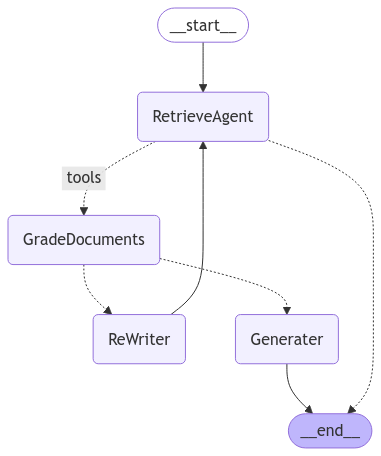

In [7]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [8]:
import pprint

inputs = {
    "messages": [
        ("user", "What does Lilian Weng say about the types of agent memory?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'RetrieveAgent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_inok0yb9', 'function': {'arguments': '{"query":"Lilian Weng agent memory types"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'stop', 'model_name': 'llama3.2', 'system_fingerprint': 'fp_ollama'}, id='run-177085eb-09f1-4a08-af47-fa2afdf36113-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'Lilian Weng agent memory types'}, 'id': 'call_inok0yb9', 'type': 'tool_call'}])]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
"Output from node 'GradeDocuments':"
'---'
{ 'messages': [ ToolMessage(content='Citation\nCited as:\n\nWeng, Lilian. (Jun 2023). “LLM-powered Autonomous Agents”. Lil’Log. https://lilianweng.github.io/posts/2023-06-23-agent/.\n\nCitation\nCited as:\n\nWeng, Lilian. (Jun 2023). “LLM-powered Autonomous Agents”. Lil’Log. https://lilianweng